# 0. Import thư viện

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

# 1. Data Preprocessing
## 1.0. Data Loading

In [ ]:
df = pd.read_csv('data/kill_match_stats.csv')

In [ ]:
df.head()

In [ ]:
df.drop(columns = ['killer_name', 'victim_name', 'killer_placement', 'victim_placement', 'match_id'], inplace = True)

In [ ]:
df = df[df['map'] == 'ERANGEL'].reset_index(drop = True)

In [ ]:
df.drop(columns = ['map'], inplace = True)

In [ ]:
df.rename(columns = {
    'killer_position_x': 'kx', 
    'killer_position_y': 'ky',
    'victim_position_x': 'vx',
    'victim_position_y': 'vy'
},inplace = True)

In [ ]:
df.head()

<span style="color:red">Câu lệnh bên dưới chỉ thực hiện một lần duy nhất trên máy một thành viên duy nhất. Sau khi thực hiện, tiến hành lưu trữ df thành file kill_match_stats_v1.csv, các thành viên khác chỉ cần load file này vào là được, không cần chạy lại câu lệnh `to_csv` để tránh mất thời gian<span>

In [ ]:
df.to_csv('data/kill_match_stats_v1.csv', index = False)

## 1.1. Data Cleaning

In [3]:
df = pd.read_csv('data/kill_match_stats_v1.csv')
df.head()

,killed_by,kx,ky,time,vx,vy
0,Down and Out,496989.8,312569.7,1035,497385.4,331528.2
1,M16A4,496989.8,312569.7,1035,497819.4,331981.3
2,AKM,460416.7,414748.8,1422,459817.9,414426.3
3,AKM,488034.1,347220.3,1210,487444.2,347651.0
4,SKS,501062.9,425078.6,1818,493043.4,434458.1


### 1.1.1. Missing values

Kiểm tra missing value trên tất cả các cột

In [4]:
df.isnull().sum()

killed_by         0
kx           741597
ky           741597
time              0
vx                0
vy                0
dtype: int64

In [5]:
print(f'Số dòng của df: {df.shape[0]:,}')

Số dòng của df: 10,865,476


Ở đây có khoảng hơn 700000 missing value ở 2 cột `kx` và `ky` so với khoảng 10,000,000 dòng dữ liệu chỉ chiếm 7%, ta có thể dễ dàng loại bỏ các dòng này. Tuy nhiên ta có thể quan sát các dòng này một chút

In [6]:
df[df['kx'].isnull()]['killed_by'].value_counts()

Bluezone                           468994
Down and Out                       141913
Falling                             61571
Drown                               41150
RedZone                             13683
Uaz                                  4451
Dacia                                3002
Buggy                                2091
Hit by Car                           1719
Motorbike                             994
Motorbike (SideCar)                   895
Punch                                 514
Grenade                               330
death.Buff_FireDOT_C                  145
death.RedZoneBomb_C                    90
Boat                                   28
death.ProjMolotov_DamageField_C        24
SCAR-L                                  1
Aquarail                                1
S686                                    1
Name: killed_by, dtype: int64

Quan sát cột `killed_by` thấy nguyên nhân gây kill ở các dòng `kx` và `ky` trống ta thấy chủ yếu các nguyên nhân này thuộc vào loại Zone (các vùng gây sát thương), các loại xe, các loại vũ khí ném và các nguyên nhân tự thân (`'Falling': Ngã, Drown: Đuối nước`). Đối vơi các nguyên nhân này, không có killer, do đó không có tọa độ của killer. Ta có thể tạm gán tọa độ `kx` và `ky` của các dòng này bằng với tọa độ của victim `vx` và `vy`

In [7]:
df.loc[df['kx'].isnull(), 'kx'] = df['vx']
df.loc[df['ky'].isnull(), 'ky'] = df['vy']

### 1.1.2. Duplicated values

In [8]:
df.duplicated().sum()

257932

Dùng hàm `duplicated` để kiểm tra các dòng trùng nhau, ta thấy có 257932 dòng dữ liệu bị trùng. Tuy nhiên ta có thể quan sát kĩ hơn các dòng này 

In [9]:
data = df[df.duplicated()]

In [10]:
data[['kx', 'ky', 'vx', 'vy']].value_counts()

kx        ky        vx        vy      
0.0       0.0       0.0       0.0         257127
399045.9  300804.1  0.0       0.0              2
482652.2  446492.6  0.0       0.0              2
446353.9  629764.4  446300.3  629816.6         1
444775.8  623105.9  444581.1  623158.9         1
                                           ...  
348630.2  312316.8  350118.1  318378.7         1
349536.5  563234.7  349230.2  564633.3         1
349832.6  565963.8  350066.0  566620.0         1
349866.4  563824.9  354611.3  570966.2         1
738463.6  434072.6  738463.6  434072.6         1
Length: 804, dtype: int64

Quan sát các giá trị khác nhau của các cột tọa độ, ta nhận thấy đa số các cột trùng nhau có tọa độ killer và victim nằm ở (0, 0), nghĩa là ở góc bản đồ, nơi không có địa hình (sẽ được minh họa kỹ hơn ở phần trực quan hóa dữ liệu). Đây có thể là lỗi trong quá trình game vận hành, số lượng các dòng bị lỗi cũng chỉ khoảng 2,5% dữ liệu, ta có thể đơn giản xóa đi các dòng này

In [11]:
df.drop_duplicates(inplace = True, ignore_index = True)

### 1.1.3. Outliers

Hiện tại `df` có 1 cột categorical là `killed_by` và 5 cột còn lại là numerical. Đối với cột `categorical`, nhóm sử dụng hàm value_counts để xác định outliers, còn đối với các cột numerical, nhóm sử dụng boxplot, kết hợp với thông tin về bản đồ của game để xác định và xử lí các outliers

In [12]:
print(df['killed_by'].value_counts().sort_values())

death.PlayerMale_A_C                     1
Aquarail                                21
death.RedZoneBomb_C                     90
death.ProjMolotov_C                    251
Boat                                  1742
death.Buff_FireDOT_C                  2711
Sickle                                4338
Crowbar                               4704
AUG                                   4830
Machete                               5377
death.ProjMolotov_DamageField_C       7086
Buggy                                 7443
Motorbike                             9451
Motorbike (SideCar)                  11132
P18C                                 13241
Mk14                                 13324
RedZone                              13587
Pan                                  15167
Crossbow                             18836
Dacia                                19557
Drown                                21371
AWM                                  23648
M249                                 25572
VSS        

Quan sát cột `killed_by`, ta thấy một vài outlier là `death.PlayerMale_A_C`, `death.RedZoneBomb_C`, `Aquarial`, `death.ProjMolotov`, `Boat`, `death.Buf_FireDOT_C`. Tuy là outliers nhưng các nguyên nhân gây kill này vẫn tồn tại trong game, do ít được sử dụng nên được ghi nhận ít. Nhóm có tra cứu thì nhận thấy ngoài `death.PlayerMale_A_C` và `death.Buff_FireDOT_C`, các nguyên nhân còn lại đều hợp lệ, chỉ bị sai tên, sẽ được sửa ở phần Data Quality bên dưới. Do dó ở cột `killed_by`, nhóm chỉ thực hiện xóa các dòng có `death.PlayerMale_A_C` và `death.Buff_FireDOT_C` của cột `killed_by`

In [13]:
df = df[(df['killed_by'] != 'death.PlayerMale_A_C') & (df['killed_by'] != 'death.Buff_FireDOT_C') ]

Đối với 5 cột numerical thì chỉ có cột `time` là khác ý nghĩa với 4 cột tọa độ còn lại, ta gom nhóm 4 cột tọa độ vào cùng một boxplot

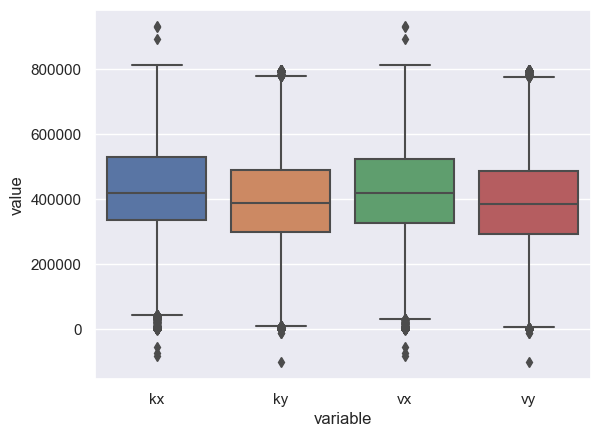

In [14]:
sns.boxplot(x = 'variable', y = 'value', data = pd.melt(df[['kx', 'ky', 'vx', 'vy']]));

Quan sát các giá trị tọa độ, ta nhận ra đa số các giá trị đều nằm trong khoảng từ 0 tới 800,000. Đây cũng là khoảng dữ liệu hợp lệ đã được đề cập trong mô tả dữ liệu của tác giả. Các giá trị ngoại lai lớn hơn 0 và nhỏ hơn 800,000 cũng xuất hiện không nhiều, không gây ảnh hưởng tới việc phân tích dữ liệu về sau, nên ta có thể chấp nhận các giá trị này. Do đó ở đây nhóm chỉ loại bỏ các giá trị tọa độ lớn hơn 800,000 hoặc nhỏ hơn 0.

In [15]:
df = df[(df['kx'] <= 800000) & (df['kx'] >= 0) 
        & (df['ky'] <= 800000) & (df['ky'] >= 0)
        & (df['vx'] <= 800000) & (df['vx'] >= 0)
        & (df['vy'] <= 800000) & (df['vy'] >= 0)]

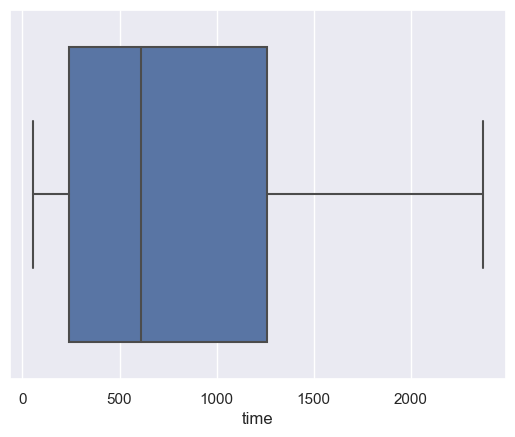

In [16]:
sns.boxplot(x = df['time']);

Cột `time` không có outlier do đó ta không cần phải xử lí

## 1.2. Data Quality Assesement
Tại bước này, nhóm tiến hành kiểm tra độ nhất quán dữ liệu, chủ yếu là ở cột `killed_by`, thêm một số cột mới có ý nghĩa phân tích dựa trên các cột đã có

### 1.2.1 Killed_by
Như đã đề cập ở phần 1.1.3, cột `killed_by` có một vài giá trị có vẻ khác với các giá trị còn lại. Nhóm đã tiến hành tra cứu và dựa vào hiểu biết của mình về game để chỉnh sửa các giá trị này cho phù hợp

Qua tìm hiểu, nhóm ghi nhận được:
- `death.RedZoneBomb_C` là cách thể hiện khác của `RedZone`
- `death.ProjMolotov_C` và `death.ProjMolotov_DamageField_C` đều là kill do bom xăng Molotov gây ra. Tuy nhiên điểm khác biệt nằm ở chỗ nếu victim tử trận khi bị đốt cháy trong đám lửa của xăng, `killed_by` sẽ là `death.ProjMolotov_C` (video bên phải bên dưới). Nếu người chơi tử trận do lửa còn đốt cháy trên người sau khi đã thoát khỏi đám cháy của Molotov, `killed_by` sẽ được ghi nhận là `death.ProjMolotov_DamageField_C` (video bên trái bên dưới). 

Do đó nhóm quyết định đối các giá trị `death.RedZoneBomb_C` thành `RedZone`, đổi cả 2 giá trị `death.ProjMolotov_C` và `death.ProjMolotov_DamageField_C` thành `Molotov`

<iframe src='https://gfycat.com/ifr/ShockingBrokenBrahmancow' frameborder='0' scrolling='no' allowfullscreen width='640' height='404' allow='autoplay'></iframe>

<iframe src='https://gfycat.com/ifr/ImperfectWhimsicalDrafthorse' frameborder='0' scrolling='no' allowfullscreen width='640' height='404' allow='autoplay'></iframe>

Nhóm cũng nhận thấy `Bluezone` và `RedZone` có sự khác biệt về chữ `z` và `Z`, dù cả 2 đối tượng này đều chỉ các zone. Để tránh nhầm lẫn trong lập trình, nhóm cũng sẽ replace `Bluezone` thành `BlueZone`

In [17]:
df.replace({
    'death.RedZoneBomb_C': 'RedZone',
    'death.ProjMolotov_C': 'Molotov',
    'death.ProjMolotov_DamageField_C': 'Molotov',
    'Bluezone': 'BlueZone'
}, inplace = True)

### 1.2.2. Các cột tọa độ
Như đã đề cập, khoảng hợp lệ của các tọa độ là từ 0 tới 800,000. Hiện tại trong df, các cột tọa độ là số thực. Tuy nhiên trong game, khoảng cách giữa 2 cạnh bản đồ là 8,8,000m, do đó nhóm nhận thấy có thể quay tọa độ từ khoảng 0 tới 800,000 thành 0 tới 8,000, đồng thời làm tròn các tọa độ thành số nguyên (vì sự khác biệt ở sau dấu phẩy thập phân không có ý nghĩa khi khoảng dữ liệu trải dài từ 0 tới 800,000)

### 1.2.3. Thêm một số cột khác
#### 1.2.3.1. Distance
Một tiêu chí đánh giá quan trọng của kill là khoảng cách giữa killer và victim, phần nào cung cấp thêm thông tin về giao tranh đã xảy ra. Khoảng cách ở đây đưuọc tính theo công thức Euclid
$$
dis = \sqrt{(kx - vx)^2 + (ky - vy)^2}
$$
Ở đây nhóm cũng sẽ làm tròn khoảng cách thành số nguyên để tiết kiệm chi phí lưu trữ.

#### 1.2.3.2. Phase
Ngoài thời gian `time`, ta có thể dùng `phase` để xác định khoảng thời gian diễn ra giao tranh. Mỗi trận đấu có 9 phase, bắt đầu từ phase 1 tới 9. Mỗi phase sẽ diễn ra trong một khoảng thời gian nhất định, trong khoảng thời gian này, bluezone sẽ đứng yên. Tới cuối mỗi phase, bluezone sẽ thu hẹp lại, ép người chơi di chuyển vào trung tâm, và chuyển sang phase tiếp theo. Thời gian dành cho mỗi phase sẽ giảm dần cùng với kích thước bluezone tại phase đó. Theo tra cứu của nhóm tại http://battlegrounds.party/circle/, thời gian cho từng phase sẽ như sau:
|Phase|Bắt đầu|Kết thúc|
|-----|-------|--------|
|1|121|690|
|2|691|990|
|3|991|1210|
|4|1211|1390|
|5|1391|1550|
|6|1551|1670|
|7|1671|1790|
|8|1791|1860|
|9|1861|1950|

Từ giây thứ 1 (ngay sau khi lên máy bay) tới giây thứ 120s, bluezone chưa xuất hiện nên không được tính là phase 1. Tuy nhiên để thuận tiện, nhóm sẽ gom khoảng thời gian này vào phase 1

In [18]:
phase_df = pd.DataFrame({
    'time': [1, 691, 991, 1211, 1391, 1551, 1671, 1791, 1861],
    'phase': [1, 2, 3, 4, 5, 6, 7, 8, 9],
})

In [19]:
df['phase'] = pd.merge_asof(df[['time']].sort_values(by = ['time']).reset_index(), phase_df, on = 'time').sort_values(by = ['index']).reset_index(drop = True)['phase']

#### 1.2.3.3. Type

Quan sát cột `killed_by`, nhóm nhận thấy có quá nhiều giá trị categorical. Nhóm quyết định sẽ gom nhóm nguyên nhân đã được quy ước sẵn trong game:
- AR: `A`ssualt `R`iffle - Súng trường hay trung liên
- DMR: `D`esignated `M`arksman `R`iffl - Súng trường thiện xạ
- SR: `S`niper `R`iffle - Súng ngắm
- SMG: `S`ub `M`achine `G`un - Tiểu liên
- LMG: `L`ight `M`achine `G`un - Súng máy hạng nhẹ
- Shotgun: Súng săn hay súng hoa cải
- Handgun: Súng ngắn, nhóm cũng sẽ gom `Crossbow (nỏ)` vào nhóm này
- Melee: Vũ khí cầm tay, nhóm quyết định gom `Punch (nắm đấm)` vào nhóm này
- Zone: Các vùng gây sát thương, gồm `BlueZone` và `RedZone`
- Throwable: Các loại vũ khí ném gồm `Grenade (lựu đạn)` và `Molotov (bom xăng)`
- Vehicle: phương tiện di chuyển
- Self: các nguyên nhân tự thân gồm `Falling (té ngã)` và `Drown (đuối nước)`

Tuy nhiên có 2 giá trị cần lưu ý ở đây:
- `Down and Out`: khi người chơi tham gia trận đấu thể thức nhóm 2, 4 người thì khi mức máu trở về 0, người chơi sẽ không tử trận ngay và rơi vào trạng thái `'knock'` (không thể sử dụng vũ khí, hồi máu, tốc độ di chuyển rất chậm, không thể di chuyển trên xe, máu liên tục giảm). Nếu đồng đội của người chơi này không `'cứu'` kịp thời, người chơi này sẽ tử trận và được ghi nhận là một sự kiện `'Down and Out'`. Do không rõ nguyên nhân gây kill ban đầu là gì, nhóm quyết định loại bỏ các dòng này.
- `Hit by Car`: bị đụng xe. Bởi vì đã có các giá trị khác nêu rõ loại xe gây tai nạn (`Dacia`, `Uaz`, ...) nên nhóm cũng không rõ `Hit by Car` có ý nghĩa gì khác. Thêm vào đó là số lượng các dòng `Hit by Car` chỉ chiếm 1% dữ liệu nên nhóm quyết định loại bỏ các dòng này


In [20]:
type_df = pd.DataFrame(list({
    'M416': 'AR', 'SCAR-L': 'AR', 'AKM': 'AR', 'Groza': 'AR', 'M16A4': 'AR', 'AUG': 'AR',
    'SKS': 'DMR', 'Mini 14': 'DMR', 'Mk14': 'DMR', 'VSS': 'DMR',
    'Kar98k': 'SR', 'AWM': 'SR', 'M24': 'SR',
    'M249': 'LMG', 'DP-28': 'LMG',
    'UMP9': 'SMG', 'Vector': 'SMG', 'Tommy Gun': 'SMG', 'Micro UZI': 'SMG',
    'S1897': 'Shotgun', 'S686': 'Shotgun', 'S12K': 'Shotgun',
    'P1911': 'Handgun', 'R1895': 'Handgun', 'P92': 'Handgun', 'P18C': 'Handgun', 'Crossbow': 'Handgun',
    'Pan': 'Melee', 'Machete': 'Melee', 'Crowbar': 'Melee', 'Sickle': 'Melee', 'Punch': 'Melee',
    'BlueZone': 'Zone', 'RedZone': 'Zone',
    'Molotov': 'Throwable', 'Grenade': 'Throwable',
    'Motorbike': 'Vehicle', 'Motorbike (SideCar)': 'Vehicle', 'Dacia': 'Vehicle', 'Uaz': 'Vehicle',
    'Buggy': 'Vehicle', 'Boat': 'Vehicle', 'Aquarail': 'Vehicle',
    'Falling': 'Self', 'Drown': 'Self'
}.items()), columns = ['killed_by', 'type'])

In [21]:
df = df.join(type_df.set_index('killed_by'), on = 'killed_by', how = 'left')
df = df[(df['killed_by'] != 'Hit by Car') & (df['killed_by'] != 'Down and Out')]

Sau khi thêm 3 cột mới là dis, phase, và type, nhóm nhận ra xuất hiện một vài vấn đề mới trong missing value và outlier
#### 1.2.3.4. More of Data Cleaning
##### 1.2.3.4.1. Outlier Distance
Ta kiểm tra outlier của cột dis bằng boxplot dưới đây

Quan sát boxplot, nhóm nhận ra có khá nhiều dữ liệu khoảng cách bị lỗi (có thể do sai sót của hệ thống hoặc do cheater). Dựa vào kinh nghiệm chơi game cũng như tra cứu về các loại vũ khí, nhóm quyết định lọc khoảng cách theo các loại vũ khí như bên dưới

<AxesSubplot:xlabel='type', ylabel='dis'>

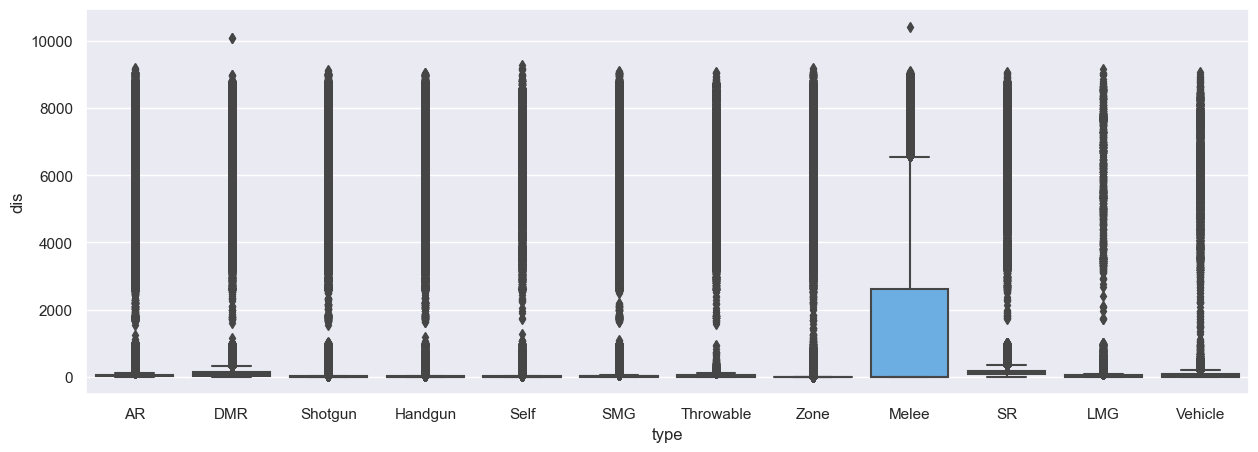

In [ ]:
plt.figure(figsize = (15, 5))
sns.boxplot(data = df, x = 'type', y = 'dis')

<AxesSubplot:xlabel='type', ylabel='dis'>

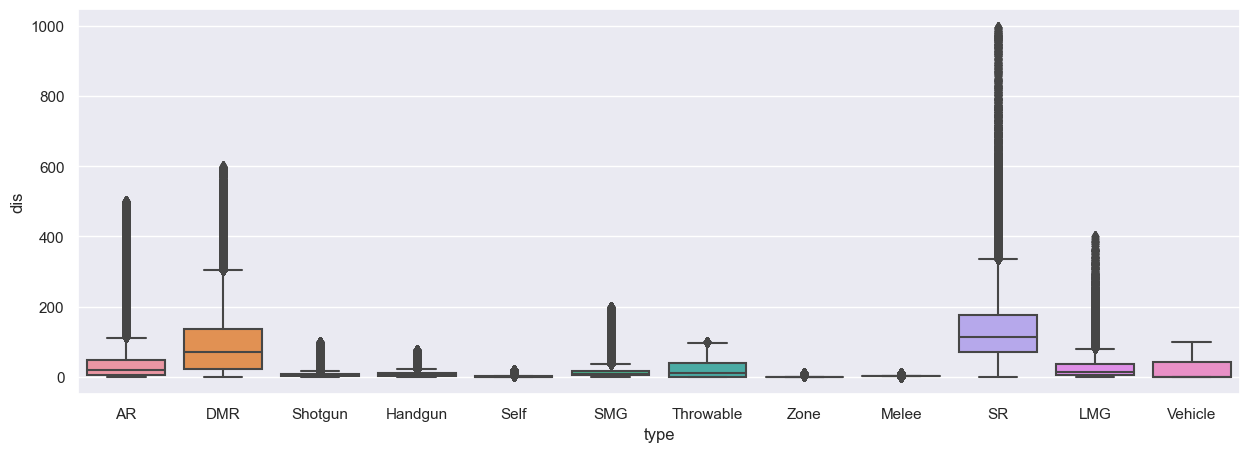

In [ ]:
plt.figure(figsize = (15, 5))

type_index = df[(
    ((df['type'] == 'Self') & (df['dis'] > 20)) |
    ((df['type'] == 'AR') & (df['dis'] > 500)) |
    ((df['type'] == 'DMR') & (df['dis'] > 600)) |
    ((df['type'] == 'SR') & (df['dis'] > 1000)) |
    ((df['type'] == 'Shotgun') & (df['dis'] > 100)) |
    ((df['type'] == 'Handgun') & (df['dis'] > 75)) |
    ((df['type'] == 'SMG') & (df['dis'] > 200)) |
    ((df['type'] == 'LMG') & (df['dis'] > 400)) |
    ((df['type'] == 'Throwable') & (df['dis'] > 100)) |
    ((df['type'] == 'Zone') & (df['dis'] > 10)) |
    ((df['type'] == 'Melee') & (df['dis'] > 10)) |
    ((df['type'] == 'Vehicle') & (df['dis'] > 100))
)].index

df = df.drop(type_index).reset_index(drop = True)
sns.boxplot(data = df, x = 'type', y = 'dis')


##### 1.2.3.4.2. Missing và Outlier Phase
Như đã đề cập, phase 9 của trận đấu kết thúc vào giây thứ 1950, nghĩa là tại giây 1950, bluezone sẽ thua nhỏm đến hết cỡ, gây sát thương lên toàn bản đồ và thường vào lúc này cũng chỉ còn nhiều nhất 1 player sống sót, do đó nhóm sẽ xóa các dòng có time lớn hơn 1960, khoảng tầm 10s sau khi vòng bo thu vào hết cỡ.

Ngoài ra khi gán phase cho cột time, nhóm cũng không rõ vì sao có một số lượng rất nhỏ các hàng không gán được phase dù có time hợp lệ. Vì số lượng các dòng này quá nhỏ, nhóm quyết định xóa toàn bộ các dòng này

In [ ]:
df = df[df['time'] <= 1950]

In [ ]:
df['phase'].isnull().sum()

2284

In [ ]:
df = df[df['phase'].notnull()]
df.reset_index(drop = True, inplace = True)

Vậy là nhóm đã thực hiện xong các công việc tiền xử lí dữ liệu, tạo thêm một số cột mới có ý nghĩa phân tích từ các cột cũ. Dữ liệu sau khi được tiền xử lí sẽ được lưu vào file kill_match_stats_v2.csv, các công đoạn sau chỉ sử dụng dữ liệu từ file này

In [ ]:
df.to_csv('data/kill_match_stats_v2.csv', index = False)